# APWP construction
This notebook allows apparent polar wander paths to be generated from dataframes of paleomagnetic poles and virtual geomagnetic poles, as returned by the functions living in the utils_compilation.py file.

In [142]:
import os
import re
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import scripts.auxiliar as aux
from scripts.utils_APWPs import plot_poles, running_mean_APWP, plot_poles_and_stats, running_mean_APWP_shape
from scripts.utils_compilation import generates_compilation, merge_all_files
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import matplotlib as mpl
import seaborn as sns
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

from scripts.auxiliar import spherical2cartesian, shape, eigen_decomposition

pd.set_option('display.max_columns', None)

### Set the path where the all the files live.

In [2]:
current_path = os.getcwd()

Generate an unfilterded DataFrame for VGPs and other for Poles

In [3]:
df_vgp_unfiltered, df_poles_original = merge_all_files(current_path)

processing file 0
processing file 1
processing file 2
processing file 3
processing file 4
processing file 5
processing file 6
processing file 7
processing file 8
processing file 9
processing file 10
processing file 11
processing file 12
processing file 13
processing file 14
processing file 15
processing file 16
processing file 17
processing file 18
processing file 19
processing file 20
processing file 21
processing file 22
processing file 23
processing file 24
processing file 25
processing file 26
processing file 27
processing file 28
processing file 29
processing file 30
processing file 31
processing file 32
processing file 33


### Set the including criterias. Note: default as None (not False)
The basic selections is the one made by the author, one should always start with that base: `'author_selection': True`.

On top of that, there's the option to include other boolean criterias as well (e.g. setting `'shallowed': True`)

In [4]:
# the basic dataset starts with the author selection
incl_criteria = {
    'author_selection': True,     # True or False; if 1, all other criteria will be ignored
    'undemagnetized': None,    # None (defaults to author selection) or True  
    'sample_count': None,      # None (defaults to author selection) or int: cutoff n (≥ x)
    'alpha_95': None,          # None (defaults to author selection) or float: cutoff A95 (≤ x degrees)
    'overprints': None,        # None (defaults to author selection) or True  
    'remagnetizations': None,  # None (defaults to author selection) or True
    'uncertain_struct': None,  # None (defaults to author selection) or True
    'rotated': None,           # None (defaults to author selection) or True
    'shallowed': None,         # None (defaults to author selection) or True [***can also implement cutoff f-value here if desired***]
    'anomalous_dir': None,     # None (defaults to author selection) or float: cutoff distance (in degrees) between vgp and mean (≤ x degrees)
    'uncertain_age': None,     # None (defaults to author selection) or float: cutoff age resolution (in Myr) between min and max (≤ x Myr)
    'distinct_age': None,      # None (defaults to author selection) or True
    'sub-time_units': None,    # None (defaults to author selection) or True (evaluates the dispersion of the supposed spot-readings)
    'rock_type': None,         # None (defaults to author selection) or string: 'all' or 'igneous' or 'sedimentary'
    'otherwise_rej': None     # None (defaults to author selection) or 'y'
    }

#### Generate the compilation following the criterias listed in the dictionary

In [5]:
df_vgp_compilation, df_pole_compilation = generates_compilation(df_vgp_unfiltered, df_poles_original, incl_criteria)

### Recomputed poles

In [6]:
df_pole_compilation[['Study','Plat','Plon','N','K','A95','min_age','max_age','mean_age']].head()

Study       Plat        Plon   N          K  \
0               Absaroka_volcanics -81.917678  328.575930  44  11.076771   
1          Beaver_River_intrusions -79.313242  327.669841  21  44.972756   
2          Bighorn_Basin_sediments -81.549042    2.761738  59  10.640570   
3       Bitterroot_Dome_intrusions -81.199091   61.199579  19   7.231338   
4  Central_Mexico_Plio-Pleistocene -88.503095  154.996894  13  61.071911   

         A95 min_age max_age  mean_age  
0   6.774448      45      54   49.5000  
1   4.792312    40.5    43.5   42.0000  
2   5.954672   52.54  59.237   55.8885  
3  13.418646    46.4    55.5   50.9500  
4   5.347242     0.0    4.51    2.2550

### A quick overview on the rejecting criteria (now included in a new compilation)

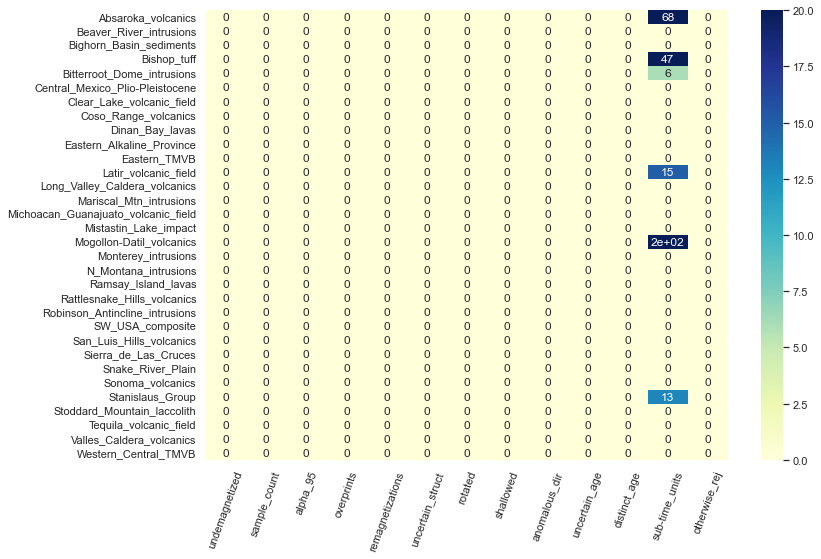

In [48]:
keys = ['undemagnetized','sample_count','alpha_95','overprints','remagnetizations','uncertain_struct','rotated','shallowed',
        'anomalous_dir','uncertain_age','distinct_age','sub-time_units','otherwise_rej']
values = [df_vgp_compilation.groupby(['Study'])[i].sum().tolist() for i in keys]

df_test = pd.DataFrame(columns = keys)
for key, value in zip(keys, values):
    df_test[key] = value
    
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(df_test, 
                 cmap="YlGnBu", yticklabels = df_vgp_compilation['Study'].unique(), annot = True, vmin = 0, vmax = 20)
ax.tick_params(axis='x', rotation=70)

## Geographic sites

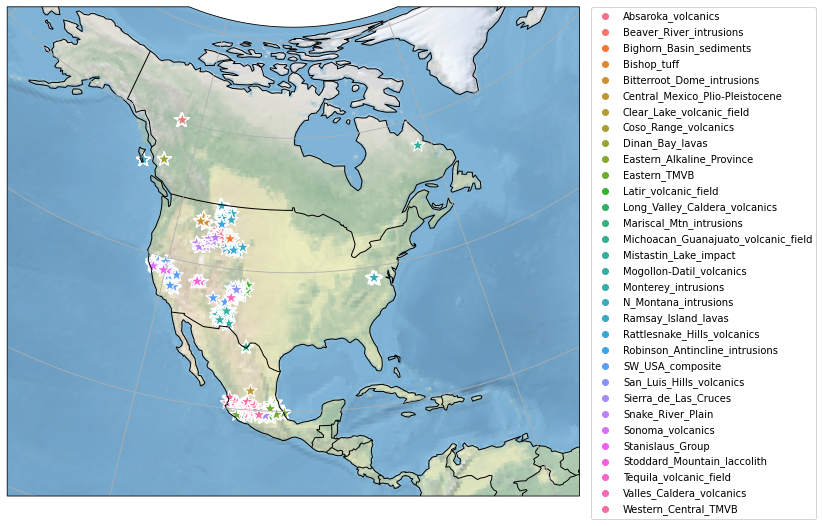

In [7]:
fig = plt.figure(figsize=(20, 9))
    
extent = [-135, -55,5, 90]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])    
    
proj = ccrs.AlbersEqualArea(central_lon, central_lat)

#ax = plt.axes(projection=proj)
ax = fig.add_subplot(1,1,1, projection=proj)
ax.set_extent(extent)

# Put a background image on for nice sea rendering.
ax.stock_img()

ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)


#if not df[df['slat'].isna()].empty: 
sns.scatterplot(x = df_vgp_compilation['slon'], y = df_vgp_compilation['slat'], hue = df_vgp_compilation['Study'], 
                 s=200, marker='*', transform=ccrs.PlateCarree())
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Plot recomputed poles

These are the firsts rows of the sheets

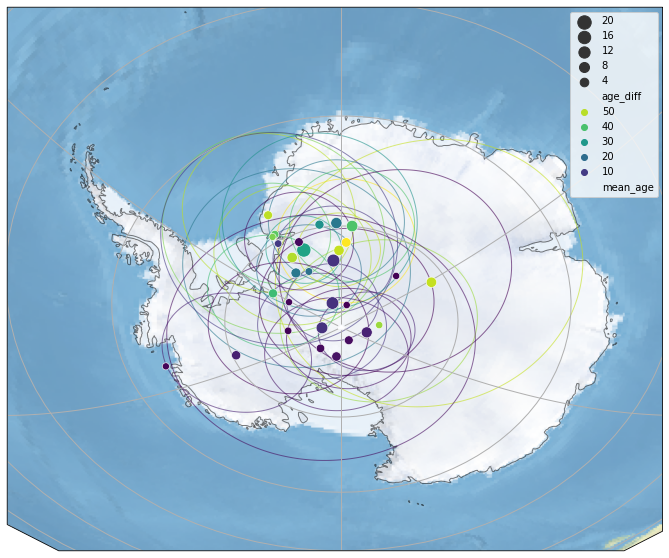

In [8]:
extent = (-180,180,-60,-90)
df_pole_compilation['age_diff'] = df_pole_compilation['max_age'] - df_pole_compilation['min_age']

plot_poles(df = df_pole_compilation, 
           plon = 'Plon', plat = 'Plat', A95 = 'A95',
           clr_scaling = 'mean_age', size_scaling = 'age_diff',
           extent = extent, plot_A95s = True, connect_poles=False)

## A quick look on the distribution of the VGP ages

Text(0.5, 1.0, 'Kernel density estimate of the distribution of ages by Study')

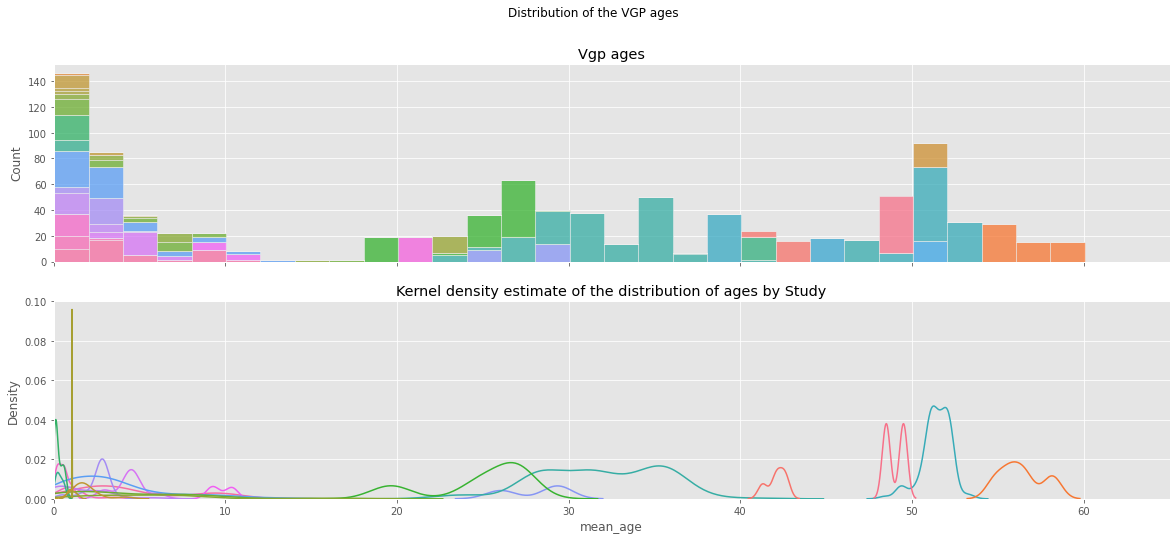

In [9]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,8))
fig.suptitle('Distribution of the VGP ages')

axes[0].set_title('Vgp ages')

sns.histplot(data = df_vgp_compilation, x = 'mean_age', hue = "Study", multiple="stack",binwidth=2, ax = axes[0], legend = False)
sns.kdeplot(data = df_vgp_compilation, x = 'mean_age', hue = "Study", ax = axes[1], legend = False)
axes[1].set(ylim=(0, 0.1))
axes[1].set(xlim=(0, 65))
axes[1].set_title('Kernel density estimate of the distribution of ages by Study')

# 1. CALCULATE RUNNING MEAN ON RECOMPUTED POLES
Calculate running mean based on a specified window length and spacing.

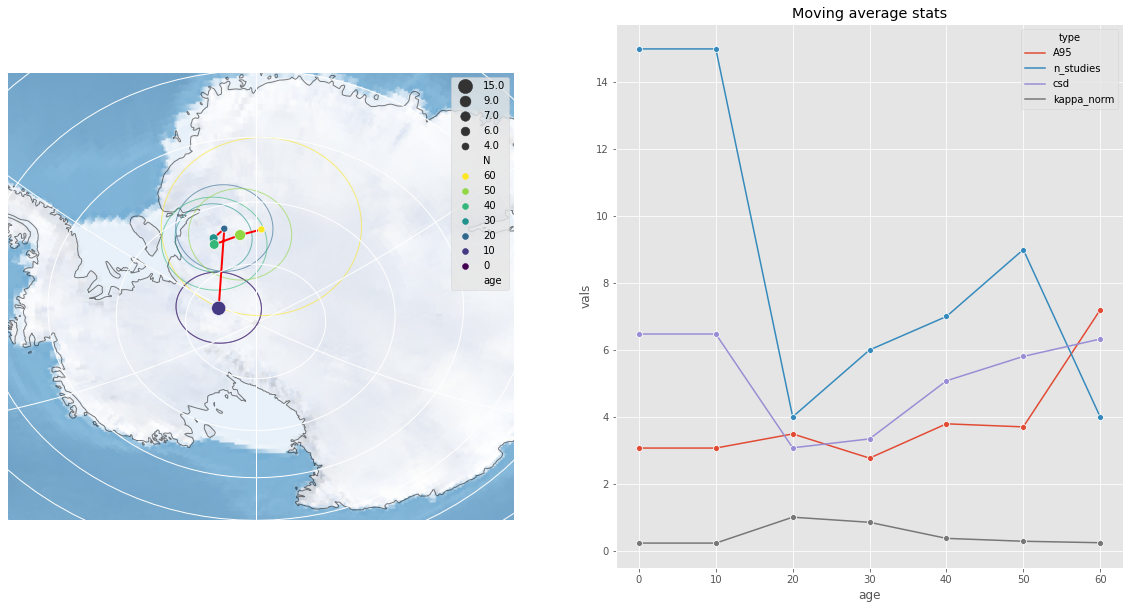

In [10]:
min_age = 0
max_age = 60
window_length = 20
time_step = 10

RM_APWP_rec_POLES = running_mean_APWP(df_pole_compilation, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)

extent = (-180,180,-70,-90)
plot_poles_and_stats(RM_APWP_rec_POLES, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

 Which is the optimal trade-off between window lenght and time step? Could we optimize these hyperparameters?

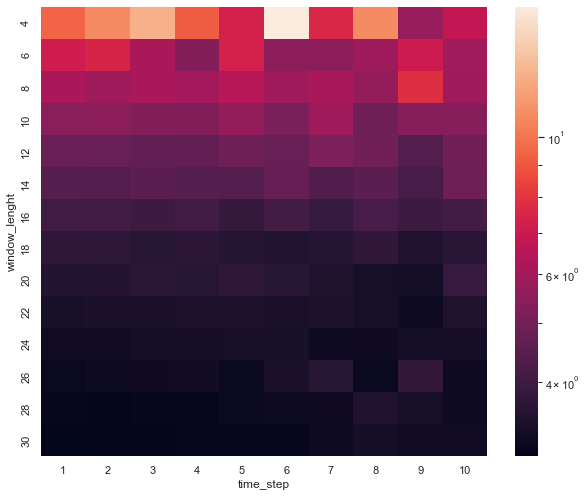

In [11]:
from matplotlib.colors import LogNorm, Normalize
window_lenghts = []
time_steps = []
mean_A95 = []

for i in np.arange(4, 31,2):
    for j in np.arange(1, 11,1):
        RM_APWP_rec_POLES = running_mean_APWP(df_pole_compilation, 'Plon', 'Plat', 'mean_age', i, j, max_age, min_age)
        mean_A95.append(RM_APWP_rec_POLES['A95'].mean())
        window_lenghts.append(i)
        time_steps.append(j)
        
df_A95s = pd.DataFrame({'window_lenght': window_lenghts, 'time_step': time_steps,'mean_A95': mean_A95})
result = df_A95s.pivot(index='window_lenght',columns='time_step',values='mean_A95')
sns.set(rc={'figure.figsize':(10,8.27)})
ax = sns.heatmap(result, norm=LogNorm())

If we re-run the same moving average but changing the hyperparameters of the model to minimize the mean of A95 for each time-step:

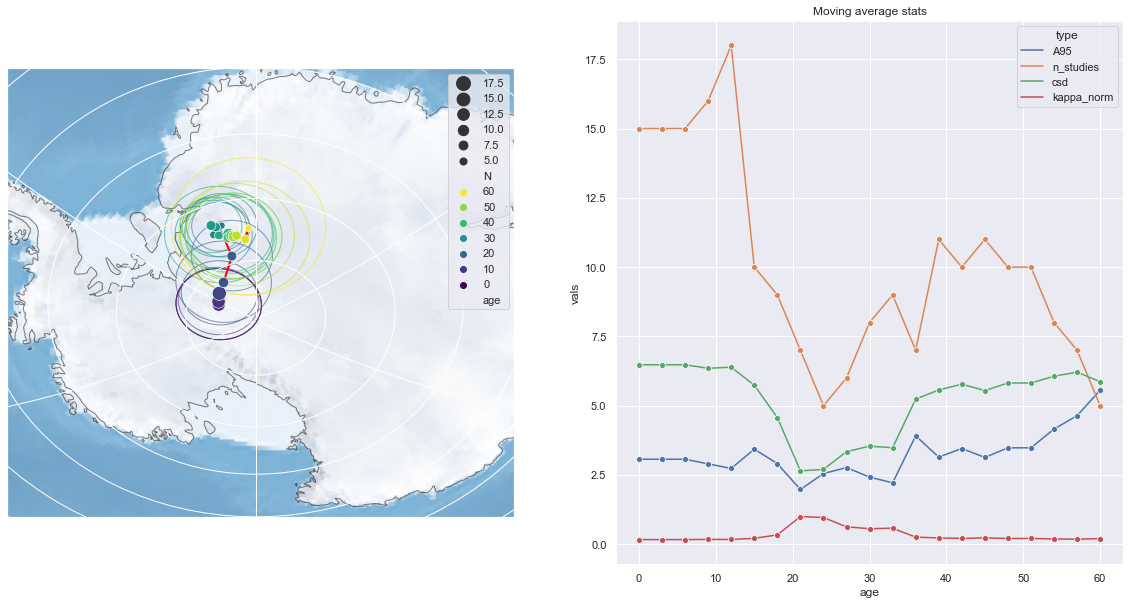

In [12]:
min_age = 0
max_age = 60
window_length = 25
time_step = 3

RM_APWP_rec_POLES = running_mean_APWP(df_pole_compilation, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)

extent = (-180,180,-70,-90)
plot_poles_and_stats(RM_APWP_rec_POLES, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

# 2. Moving average on parametrically resampled vgps ('pseudo vgps')

First we need to generate a new dataset by drawing parametrically from the study-level poles.

In the present formulation we follow
a very conservative apporach to assign ages to each VGP, it is taken at random between
the lower and upper bounds of the distribution of reported VGPs.

In [13]:
def get_pseudo_vgps(df):  
    '''
    takes a DF with paleomagnetic poles and respective statistics, it draws N randomly generated VGPs
    following the pole location and kappa concentration parameter. In the present formulation we follow
    a very conservative apporach for the assignaiton of ages to each VGP, it is taken at random between
    the lower and upper bounds of the distribution of reported VGPs.
    Note: column labels are presently hard-coded into this, if relevant.
    '''
    Study, age_bst, vgp_lat_bst, vgp_lon_bst = [], [], [], []

    for index, row in df.iterrows():
        
        # we first generate N VGPs following with N the number of VGPs from the original pole.
        directions_temp = ipmag.fishrot(k = row.K, n = row.N, dec = row.Plon, inc = row.Plat, di_block = False)
        
        vgp_lon_bst.append(directions_temp[0])
        vgp_lat_bst.append(directions_temp[1])
    
        age_bst.append([np.random.randint(np.floor(row.min_age),np.ceil(row.max_age)) for _ in range(row.N)])
        Study.append([row.Study for _ in range(row.N)])
    
    vgp_lon_bst = [item for sublist in vgp_lon_bst for item in sublist]
    vgp_lat_bst = [item for sublist in vgp_lat_bst for item in sublist] 
    age_bst = [item for sublist in age_bst for item in sublist]
    Study = [item for sublist in Study for item in sublist]
    
    dictionary = {
                  'Study': Study,
                  'plat': vgp_lat_bst,    
                  'plon': vgp_lon_bst,
                  'age': age_bst
                  }    
    
    pseudo_vgps = pd.DataFrame(dictionary)

    return pseudo_vgps

pseudo_vgps = get_pseudo_vgps(df_pole_compilation)
pseudo_vgps.head()

Study       plat        plon  age
0  Absaroka_volcanics -41.169914  309.737897   53
1  Absaroka_volcanics -80.781046  205.161004   49
2  Absaroka_volcanics -54.585600   60.451892   50
3  Absaroka_volcanics -56.569264  271.882148   45
4  Absaroka_volcanics -75.021915  238.187390   45

### Plot the pseudo vgps (parametric draws from the poles)

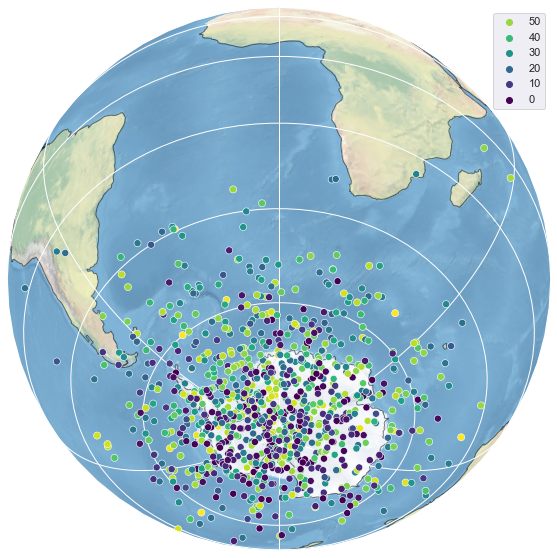

In [14]:
extent = 'global'
plot_poles(pseudo_vgps, 'plon', 'plat', None, 'age', None, extent, plot_A95s=False)

### Bootstrapped age distribution

<AxesSubplot:title={'center':'Bootstrapped age distribution (grouped by study)'}, xlabel='age', ylabel='Count'>

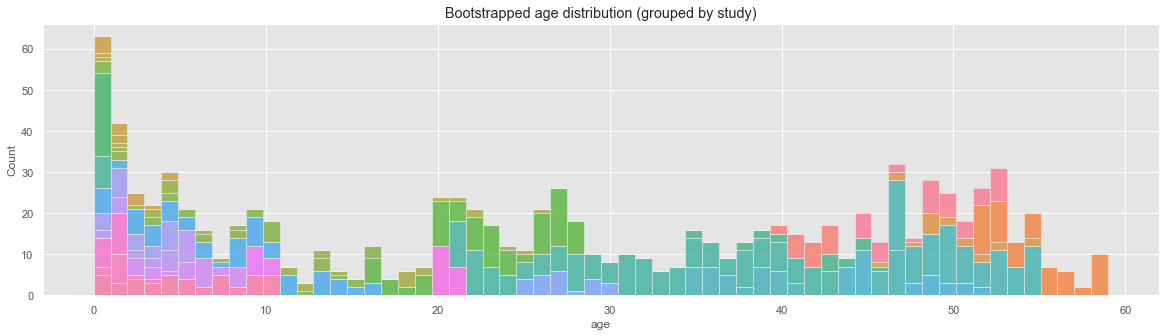

In [30]:
fig = plt.figure(figsize=(20,5))
plt.style.use('ggplot')
plt.title('Bootstrapped age distribution (grouped by study)')
sns.histplot(data = pseudo_vgps, x = 'age', hue = "Study", multiple="stack", bins = 60, legend = False)

### Compute running means (one realization)

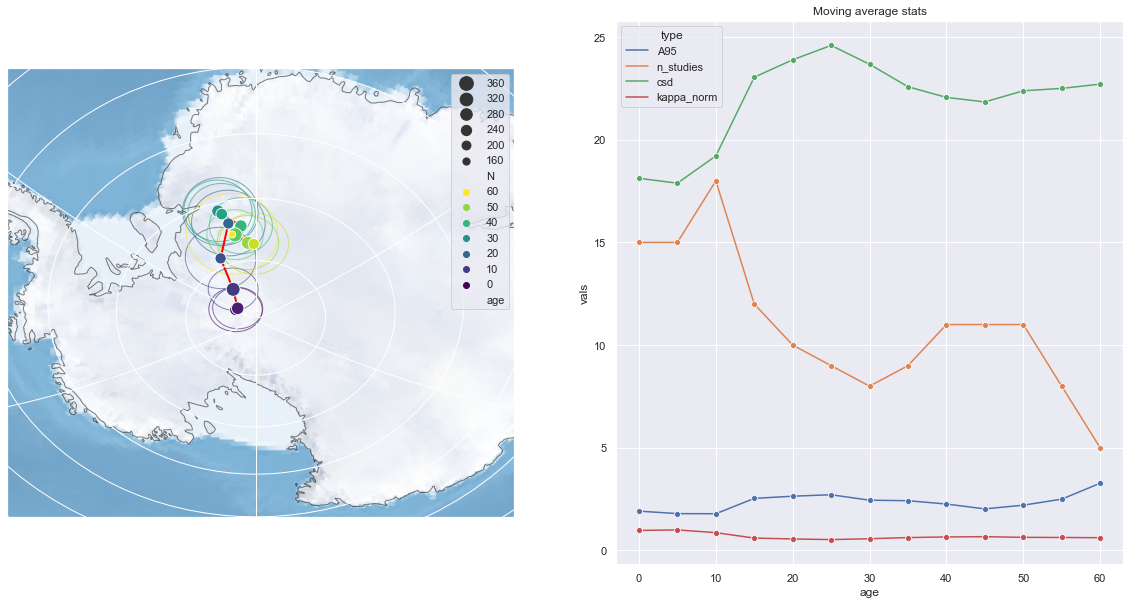

In [17]:
min_age = 0
max_age = 60
window_length = 20
time_step = 5

RM_APWP_parametric = running_mean_APWP(pseudo_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)

extent = (-180,180,-70,-90)
plot_poles_and_stats(RM_APWP_parametric, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

## We repeat this approach a number of times to get empirical confidence regions on the path

In [81]:
%%time
min_age = 0
max_age = 60
window_length = 10
time_step = 4

df_parametric_means_collection = pd.DataFrame(columns=['age','run','n_studies','k','A95','csd','plon','plat'])

for i in range(100):
    
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP(pseudo_vgps_temp, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    df_parametric_means_collection = df_parametric_means_collection.append(RM_APWP_parametric_temp, ignore_index=True)                                                                   

Wall time: 24.4 s


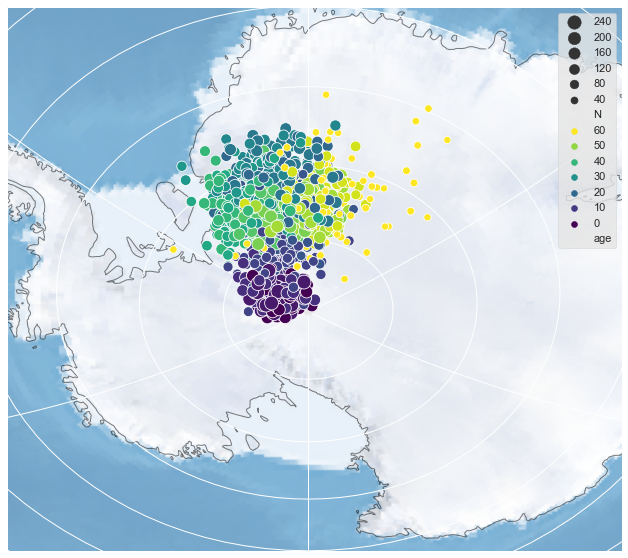

In [82]:
plot_poles(df_parametric_means_collection, 'plon', 'plat', 'A95', 'age', 'N', extent, plot_A95s=False, connect_poles=False)

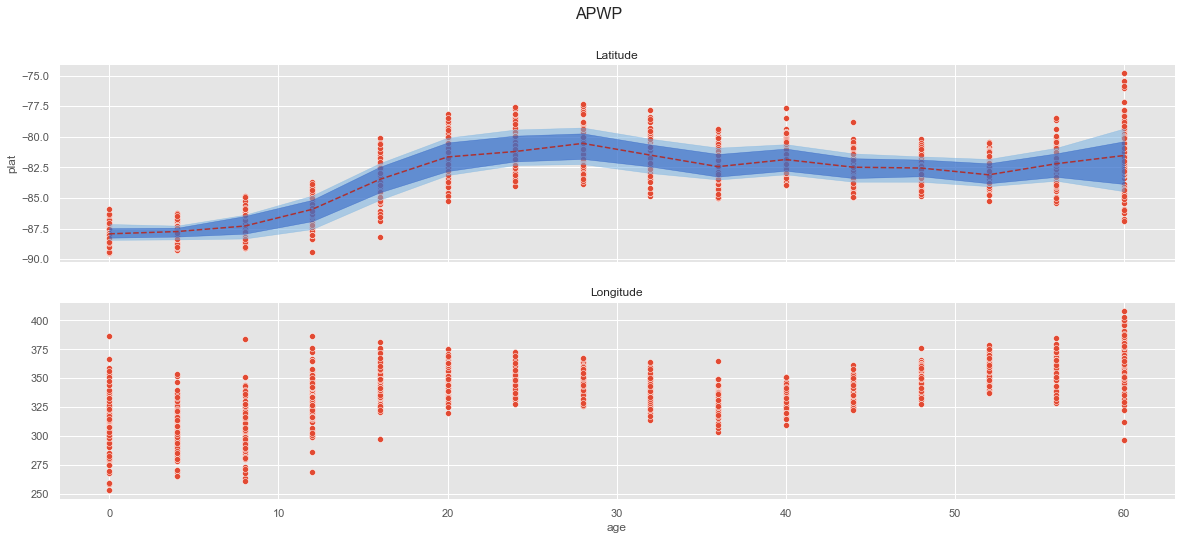

In [114]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,8))
fig.suptitle('APWP', fontsize= 16)

axes[0].set_title('Latitude', fontsize=12)
axes[1].set_title('Longitude', fontsize=12)
pltt = sns.scatterplot(data=df_parametric_means_collection, x="age", y="plat", ax = axes[0])
#sns.boxplot(data=df_parametric_means_collection, x="age", y="plat", ax = axes[0])
pltt1 = sns.scatterplot(data=df_parametric_means_collection, x="age", y= df_parametric_means_collection.apply(lambda row: row.plon + 360 if row.plon < 100 else row.plon, axis =1), ax = axes[1])

x = sorted(df_parametric_means_collection['age'].unique())

Y = df_parametric_means_collection.groupby('age')['plat']

q5 =  Y.quantile(.16).to_numpy() 
q25 = Y.quantile(.25).to_numpy()
q50 = Y.quantile(.50).to_numpy()
q75 = Y.quantile(.75).to_numpy() 
q95 = Y.quantile(.84).to_numpy() 
mean = Y.mean().to_numpy() 

pltt.fill_between(x, q5,q95, color= "#71AFE2", alpha=.50,label="0.16-0.84 percentiles")
pltt.fill_between(x, q25,q75, color= "#1A52C1", alpha=.50,label="0.25-0.75 percentiles")
pltt.plot(x, q50, '--', color="#ad3131",label="mean")

#  3. CALCULATE RUNNING MEAN ON RECOMPILED VGPS


Calculate running mean based on a specified window length and spacing.

In [79]:
# from matplotlib.colors import LogNorm, Normalize
# window_lenghts = []
# time_steps = []
# mean_A95 = []

# for i in np.arange(4, 31,2):
#     for j in np.arange(1, 11,1):
#         RM_APWP_rec_POLES = running_mean_APWP(df_vgp_compilation, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', i, j, max_age, min_age)
#         mean_A95.append(RM_APWP_rec_POLES['A95'].mean())
#         window_lenghts.append(i)
#         time_steps.append(j)
        
# df_A95s = pd.DataFrame({'window_lenght': window_lenghts, 'time_step': time_steps,'mean_A95': mean_A95})
# result = df_A95s.pivot(index='window_lenght',columns='time_step',values='mean_A95')
# sns.set(rc={'figure.figsize':(10,8.27)})
# ax = sns.heatmap(result, norm=LogNorm())

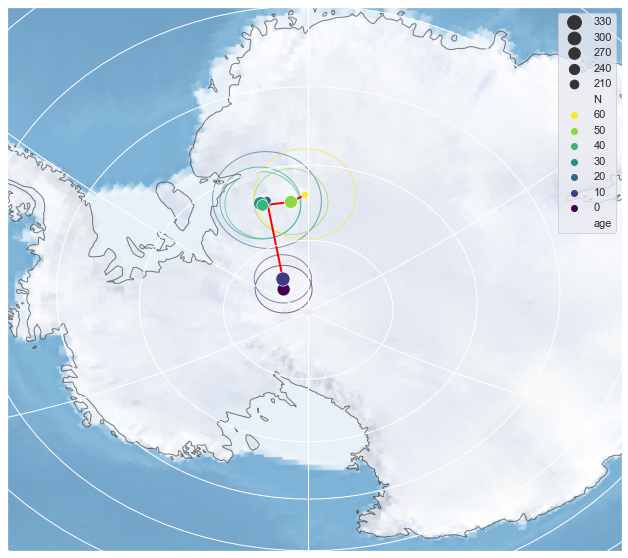

In [13]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10

RM_APWP_VGPS = running_mean_APWP(df_vgp_compilation, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)

extent = (-180,180,-70,-90)
plot_poles(RM_APWP_VGPS, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

### Shape of the windows

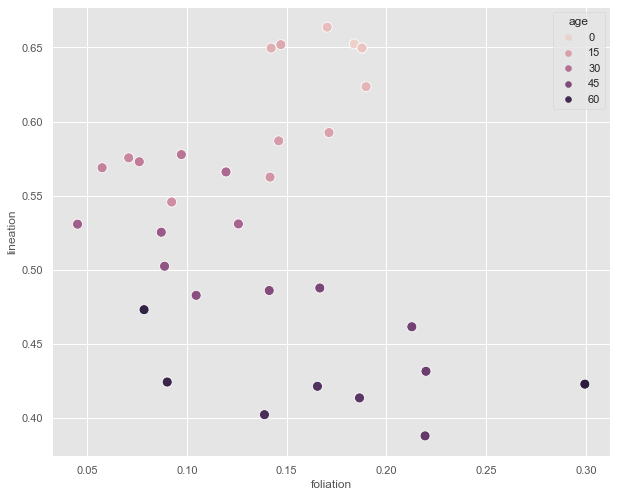

In [129]:
df_shapes = running_mean_APWP_shape(df_vgp_compilation, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
graph = sns.scatterplot(data=df_shapes, x = 'foliation' , y = 'lineation', hue = 'age', s = 100)
# graph.set_xlim(0, 1)
# graph.set_ylim(0, 1)

do the same but with bootstrapping the samples within the window age

# Botstrapping within each window

To be done: take each vgp as a pdf, take the age at random within the range of the pole statistics 

In [178]:
def running_mean_bootstrapped(data, plon_label, plat_label, age_label, window_length, time_step, max_age, min_age, n_bst = 100):
    '''
    takes a compilation of vgps and for each time window uses the bootstrap approach to construct empirical confidence bounds. 
    '''

    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)

    running_means_global = pd.DataFrame(columns=['run','age','N','k','A95','csd','plon','plat', 'foliation','lineation','collinearity','coplanarity'])

    for i in range(n_bst):
        running_means = pd.DataFrame(columns=['run','age','N','k','A95','csd','plon','plat', 'foliation','lineation','collinearity','coplanarity'])
        for age in mean_pole_ages:

            window_min = age - (window_length / 2.)
            window_max = age + (window_length / 2.)

            vgps = data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max)]
            vgps_sample = vgps.sample(n = len(vgps), replace = True)
            ArrayXYZ = np.array([spherical2cartesian([i[plat_label], i[plon_label]]) for _,i in vgps_sample.iterrows()])
            
            if len(ArrayXYZ) > 3:
                shapes = shape(ArrayXYZ)       
            else:
                shapes = [np.nan,np.nan,np.nan,np.nan]            
            
            mean = ipmag.fisher_mean(dec=vgps_sample[plon_label].tolist(), inc=vgps_sample[plat_label].tolist())
            
            if mean: # this just ensures that dict isn't empty
                running_means.loc[age] = [int(i),age, mean['n'],  mean['k'],mean['alpha95'], mean['csd'], mean['dec'], mean['inc'], 
                                          shapes[0], shapes[1], shapes[2], shapes[3]]      
            running_means.reset_index(drop=1, inplace=True)
            running_means_global = running_means_global.append(running_means)
            
    return running_means_global

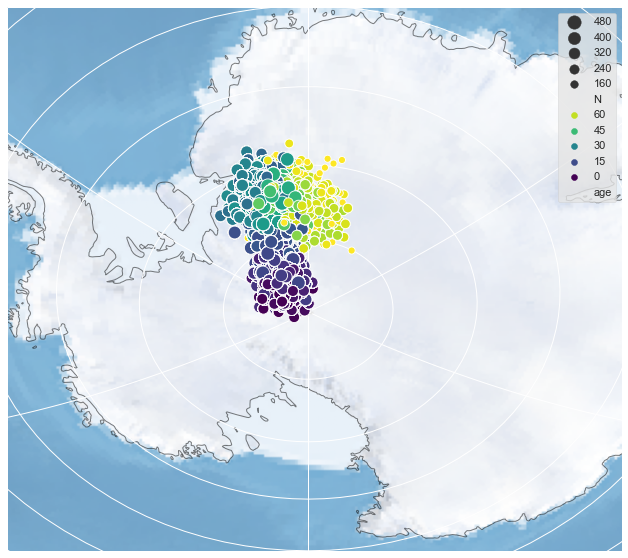

Wall time: 2min 40s


In [207]:
%%time

min_age = 0
max_age = 65
window_length = 30
time_step = 2

bst_RM = running_mean_bootstrapped(df_vgp_compilation, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
plot_poles(bst_RM, 'plon', 'plat', 'A95', 'age', 'N', extent, plot_A95s=False, connect_poles=False)

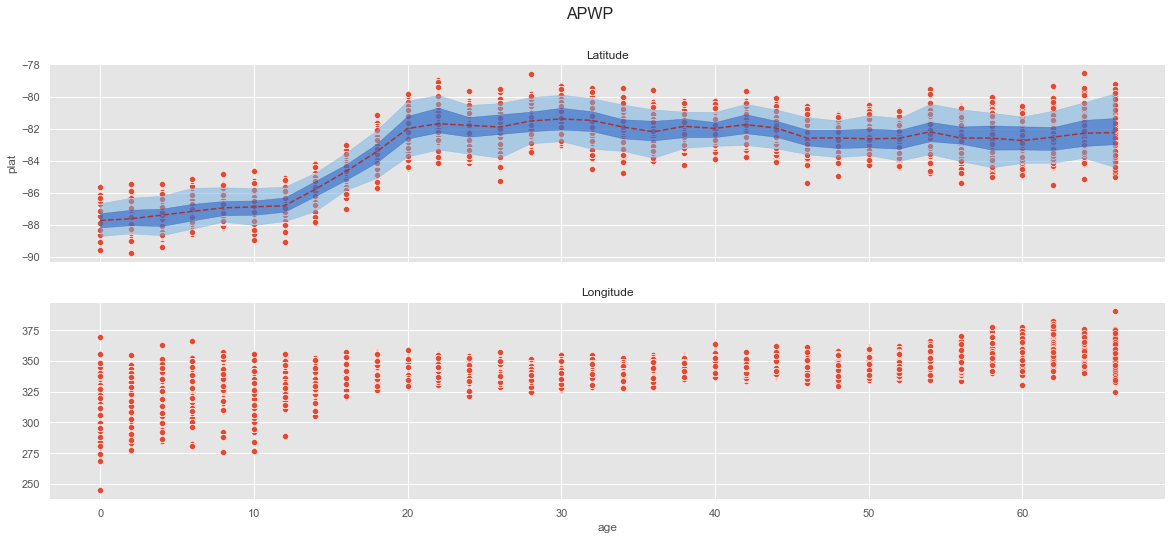

In [212]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,8))
fig.suptitle('APWP', fontsize= 16)

axes[0].set_title('Latitude', fontsize=12)
axes[1].set_title('Longitude', fontsize=12)
pltt = sns.scatterplot(data=bst_RM, x="age", y="plat", ax = axes[0])
#sns.boxplot(data=df_parametric_means_collection, x="age", y="plat", ax = axes[0])
pltt1 = sns.scatterplot(data=bst_RM, x="age", y= bst_RM.apply(lambda row: row.plon + 360 if row.plon < 100 else row.plon, axis =1), ax = axes[1])

x = sorted(bst_RM['age'].unique())

Y = bst_RM.groupby('age')['plat']

q5 =  Y.quantile(.05).to_numpy() 
q25 = Y.quantile(.25).to_numpy()
q50 = Y.quantile(.50).to_numpy()
q75 = Y.quantile(.75).to_numpy() 
q95 = Y.quantile(.95).to_numpy() 
mean = Y.mean().to_numpy() 

pltt.fill_between(x, q5,q95, color= "#71AFE2", alpha=.50,label="0.16-0.84 percentiles")
pltt.fill_between(x, q25,q75, color= "#1A52C1", alpha=.50,label="0.25-0.75 percentiles")
pltt.plot(x, q50, '--', color="#ad3131",label="mean")

### Finally, we draw a path following the density of the distribution of poles through age -the most likely path (could be improved)

## Bootstrapped shapes

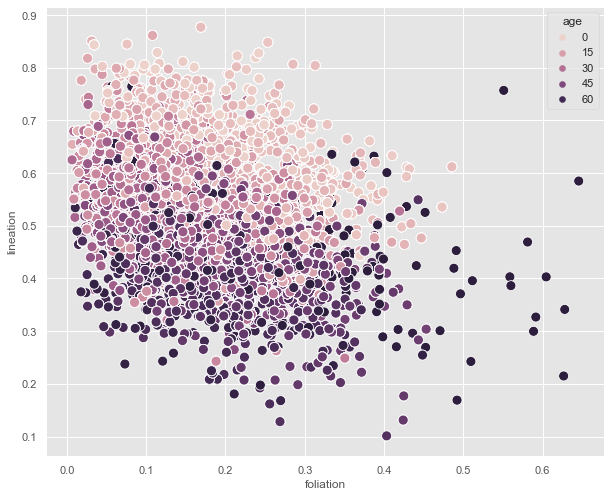

In [209]:
graph = sns.scatterplot(data=bst_RM, x = 'foliation' , y = 'lineation', hue = 'age', s = 100)

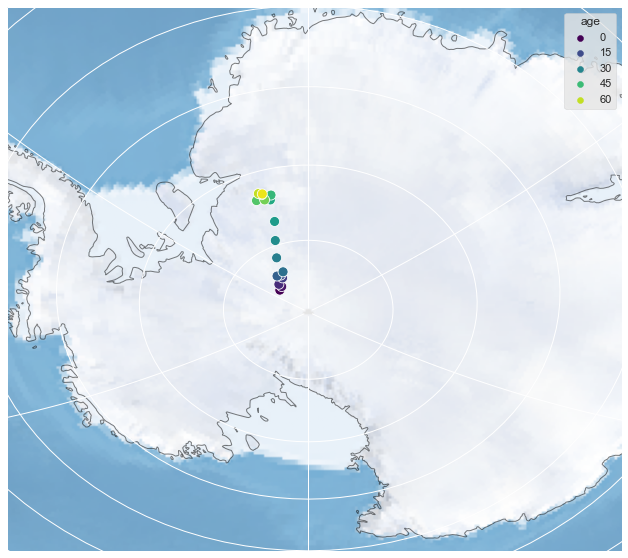

In [210]:
bst_path = pd.DataFrame()

extent = (-180,180,-70,-90)

lats = bst_RM.groupby('age')['plat']
longs = bst_RM.groupby('age')['plon']

bst_path['age'] = x = sorted(bst_RM['age'].unique())
bst_path['lat_q50'] = lats.quantile(.50)
bst_path['lon_q50'] = longs.quantile(.50)
bst_path['lat_q95'] = lats.quantile(.95)
bst_path['lon_q95'] = longs.quantile(.95)
bst_path['lat_q05'] = lats.quantile(.05)
bst_path['lon_q05'] = longs.quantile(.05)

fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0, central_latitude=-55) #30, -60
ax = plt.axes(projection=proj)    
ax.stock_img()
ax.coastlines(linewidth=1, alpha=0.5)
ax.gridlines(linewidth=1)

cmap = mpl.cm.get_cmap('viridis')
plt.plot( bst_path['lon_q50'], bst_path['lat_q50'], transform = ccrs.Geodetic(), color='red', linewidth=2.0)

sns.scatterplot(x = bst_path['lon_q50'] , y = bst_path['lat_q50'], hue = bst_path['age'], palette=cmap, s=100, transform = ccrs.PlateCarree(), zorder=4)
ax.set_extent(extent, crs = ccrs.PlateCarree())
plt.show()